# Main notebook of our project

## This project consists of 3 major parts 
- General information in movies
- Bechdel test data
    - SVM model + taking into account the proportion of women
    - GPT2 model : finetuning on bechdel test + running on all movies
    - Comparison of both models
- Feminism :
    - Creation of our own dataset of feminist movies
    - GPT2 model : finetuning on feminism dataset + running on all movies
    - Use of this data to create graphs and interactive plots
    - Graph Theory :
        - Clustering
        - Interaction visualization


        

Start by importing all the necessary elements for the project by running the next cell :

In [1]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import os
import sys
import plotly.graph_objects as go

In [2]:
# Define paths - modify them according to your own data location : 
file_source = '/Volumes/LaCie/ADA/2024/Projet/'  # Main data folder
reviews_path = '/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv'  # Reviews dataset path
bechdel_path = '/Users/shrinidhivelan/Desktop/DATA ADA Projet/movies.csv'  # Bechdel test dataset path
bechdel_path2 = '/Users/shrinidhivelan/Desktop/DATA ADA Projet/(1) Feminism/movies.csv'  # Feminism dataset path


# Create datasets
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie = create_datasets(file_source, reviews_path)

# Load reviews dataset
reviews = pd.read_csv(reviews_path)

# Parse dictionaries in MovieMetadata_df
MovieMetadata_df['Country dictionnaire'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Genre dictionnaire'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Language dictionnaire'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval)

# Merge plot summaries with movie names
movie_names_summaries_df = pd.merge(plot_summaries_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')
movie_names_character_df = pd.merge(CharacterMetadata_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')

# Load Bechdel test dataset and merge
bechdel_2 = pd.read_csv(bechdel_path2)

Movie_data_bechdel_notation_df = pd.merge(
    MovieMetadata_df, 
    bechdel_2[["title", "year", "bt_score"]], 
    left_on="Movie name", 
    right_on="title", 
    how="inner"
)

# Prepare data for model labels
summaries_bechdel_movies_df = pd.merge(
    plot_summaries_df, 
    Movie_data_bechdel_notation_df, 
    on='Wikipedia movie ID', 
    how='inner'
)

summaries_label = summaries_bechdel_movies_df[['Summaries', 'Movie name', 'bt_score']]

# Part 1 - General information in movies

## Gender Study

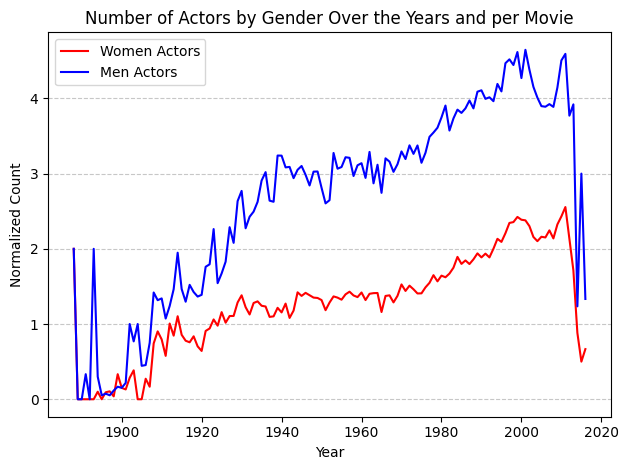

In [3]:
women_actor = CharacterMetadata_df[CharacterMetadata_df['Actor gender'] == 'F']
men_actor = CharacterMetadata_df[CharacterMetadata_df['Actor gender'] == 'M']

count_women = women_actor['Year'].value_counts().sort_index()
count_men = men_actor['Year'].value_counts().sort_index()

all_years = range(min(count_women.index.min(), count_men.index.min()), 
                  max(count_women.index.max(), count_men.index.max()) + 1)

count_women = count_women.reindex(all_years, fill_value=0)
count_men = count_men.reindex(all_years, fill_value=0)

movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index().reindex(all_years, fill_value=0)

plt.plot(count_women.index, count_women.values / movies_per_year.values, label='Women Actors', color='red')
plt.plot(count_men.index, count_men.values / movies_per_year.values, label='Men Actors', color='blue')

plt.xlabel('Year')
plt.ylabel('Normalized Count')
plt.title('Number of Actors by Gender Over the Years and per Movie')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Number of Actor by Gender over the Years and per country

In [5]:
CharacterMetadata_df

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,1992
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957


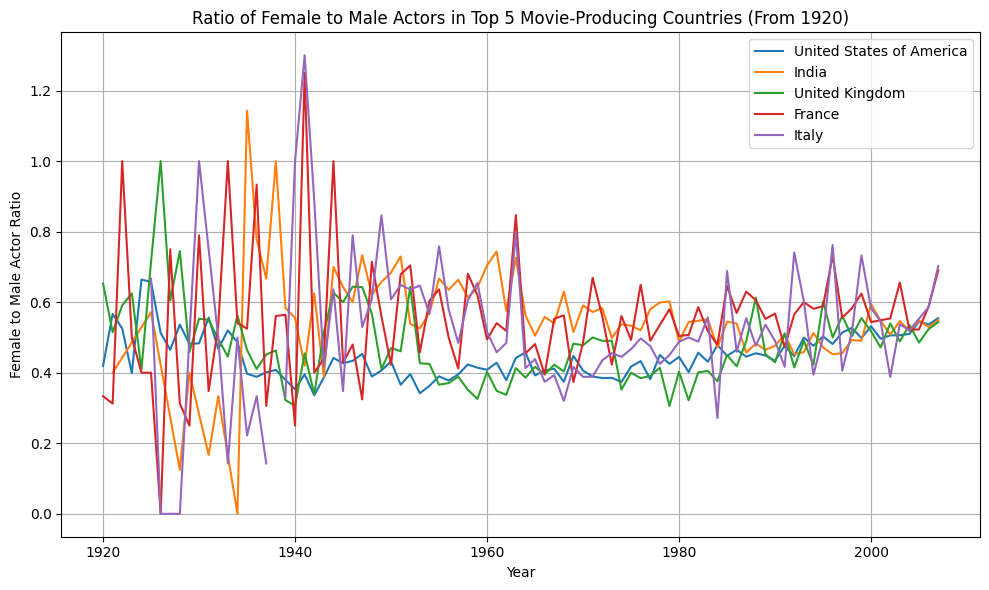

In [ ]:
# Step 1: Compute the number of female and male actors in each movies 
count_gender = CharacterMetadata_df.groupby(['Wikipedia movie ID', 'Actor gender']).size().unstack(fill_value=0)

movie_info = CharacterMetadata_df[['Wikipedia movie ID', 'Year', 'Movie countries (Freebase ID:name tuples)', 
                                   'Movie genres (Freebase ID:name tuples)']].drop_duplicates()
# Step 2: Added movie data (country, genre)
result = pd.merge(count_gender, movie_info, on='Wikipedia movie ID', how='left')
result['Country dictionnaire'] = result['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
result['Genre dictionnaire'] = result['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
result_exploded = result.explode('Country dictionnaire')

# Step 3: Compute the number of  female and male actors for each country and per year
count_gender = result_exploded.groupby(['Year', 'Country dictionnaire']).agg({'F': 'sum', 'M': 'sum'}).reset_index()

# Step 4: Compute the number of movies per year and per country
movies_per_country = result_exploded.groupby(['Year', 'Country dictionnaire']).size().reset_index(name='movies_count')
count_gender = pd.merge(count_gender, movies_per_country, on=['Year', 'Country dictionnaire'])

# Step 5: Normalisation of the results 
count_gender['F_normalized'] = count_gender['F'] / count_gender['movies_count']
count_gender['M_normalized'] = count_gender['M'] / count_gender['movies_count']
count_gender['Ratio']= count_gender['F_normalized']/count_gender['M_normalized']

## Step 6: We only take into account the 5 countries that produce the most films
top_countries = count_gender.groupby('Country dictionnaire')['movies_count'].sum().nlargest(5).index
top_countries_data = count_gender[count_gender['Country dictionnaire'].isin(top_countries)]
top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']

top_countries_data_filtered = top_countries_data[(top_countries_data['Year'] >= 1920) & (top_countries_data['Year'] < 2008) ]

fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_countries):
    country_data = top_countries_data_filtered[top_countries_data_filtered['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['Ratio'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of Female to Male Actors in Top 5 Movie-Producing Countries (From 1920)')
ax.set_xlabel('Year')
ax.set_ylabel('Female to Male Actor Ratio')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Create an interactive figure
fig = go.Figure()

# Add a trace for each country
for i, country in enumerate(top_countries):
    country_data = top_countries_data_filtered[top_countries_data_filtered['Country dictionnaire'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['Ratio'],
        mode='lines',
        name=f'{top_countries_name[i]}'
    ))

# Update layout
fig.update_layout(
    title='Ratio of Female to Male Actors in Top 5 Movie-Producing Countries (From 1920)',
    xaxis_title='Year',
    yaxis_title='Female to Male Actor Ratio',
    template='plotly_white',
    legend=dict(title="Countries"),
    xaxis=dict(showgrid=True),  # Enable grid for x-axis
    yaxis=dict(showgrid=True)   # Enable grid for y-axis
)

# Save the figure as an HTML file
#fig.write_html("female_to_male_actor_ratio_per_country.html")
fig.show()

# Part 2 - Bechdel Test



# Part 3 - Feminism